In [3]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import scanpy as sc
import numpy as np
import anndata
import matplotlib as mpl
import matplotlib.pyplot as plt
from copy import copy

import seaborn as sns

sc.settings.verbosity = 1            
sc.logging.print_header()
sc.settings.set_figure_params(figsize = [12,10],dpi =100, facecolor='white')

vir = copy(mpl.cm.viridis)
vir.set_under("lightgray")

scanpy==1.9.5 anndata==0.8.0 umap==0.5.2 numpy==1.24.4 scipy==1.10.1 pandas==2.0.3 scikit-learn==1.3.2 statsmodels==0.14.0 igraph==0.10.8 louvain==0.8.0 pynndescent==0.5.5


In [4]:
adata = sc.read_h5ad('Neuron.h5ad')

adata.obs['DL'] = 'Other Neuron'
adata.obs['DL'][adata.obs['UL_signature'] <= 0]= 'DL'

In [5]:
df = adata.obs[['age.x','condition.x','DL','Neuron_signature','DL_signature','UL_signature']].copy()

df.columns = ['age','condition','DL','Neuron_signature','DL_signature','UL_signature']
df['age'] = ['E' + str(x) for x in df['age']]

df['DL'][df['condition'] == 'ko'] = 'ko'

In [6]:
df_pivot = pd.pivot_table(df,values = ['Neuron_signature','DL_signature','UL_signature'],
                          index = ['age'],columns = ['DL'],aggfunc = 'mean')

In [7]:
import seaborn as sns

Text(0.5, 1.0, 'Average Deep Layer Signature')

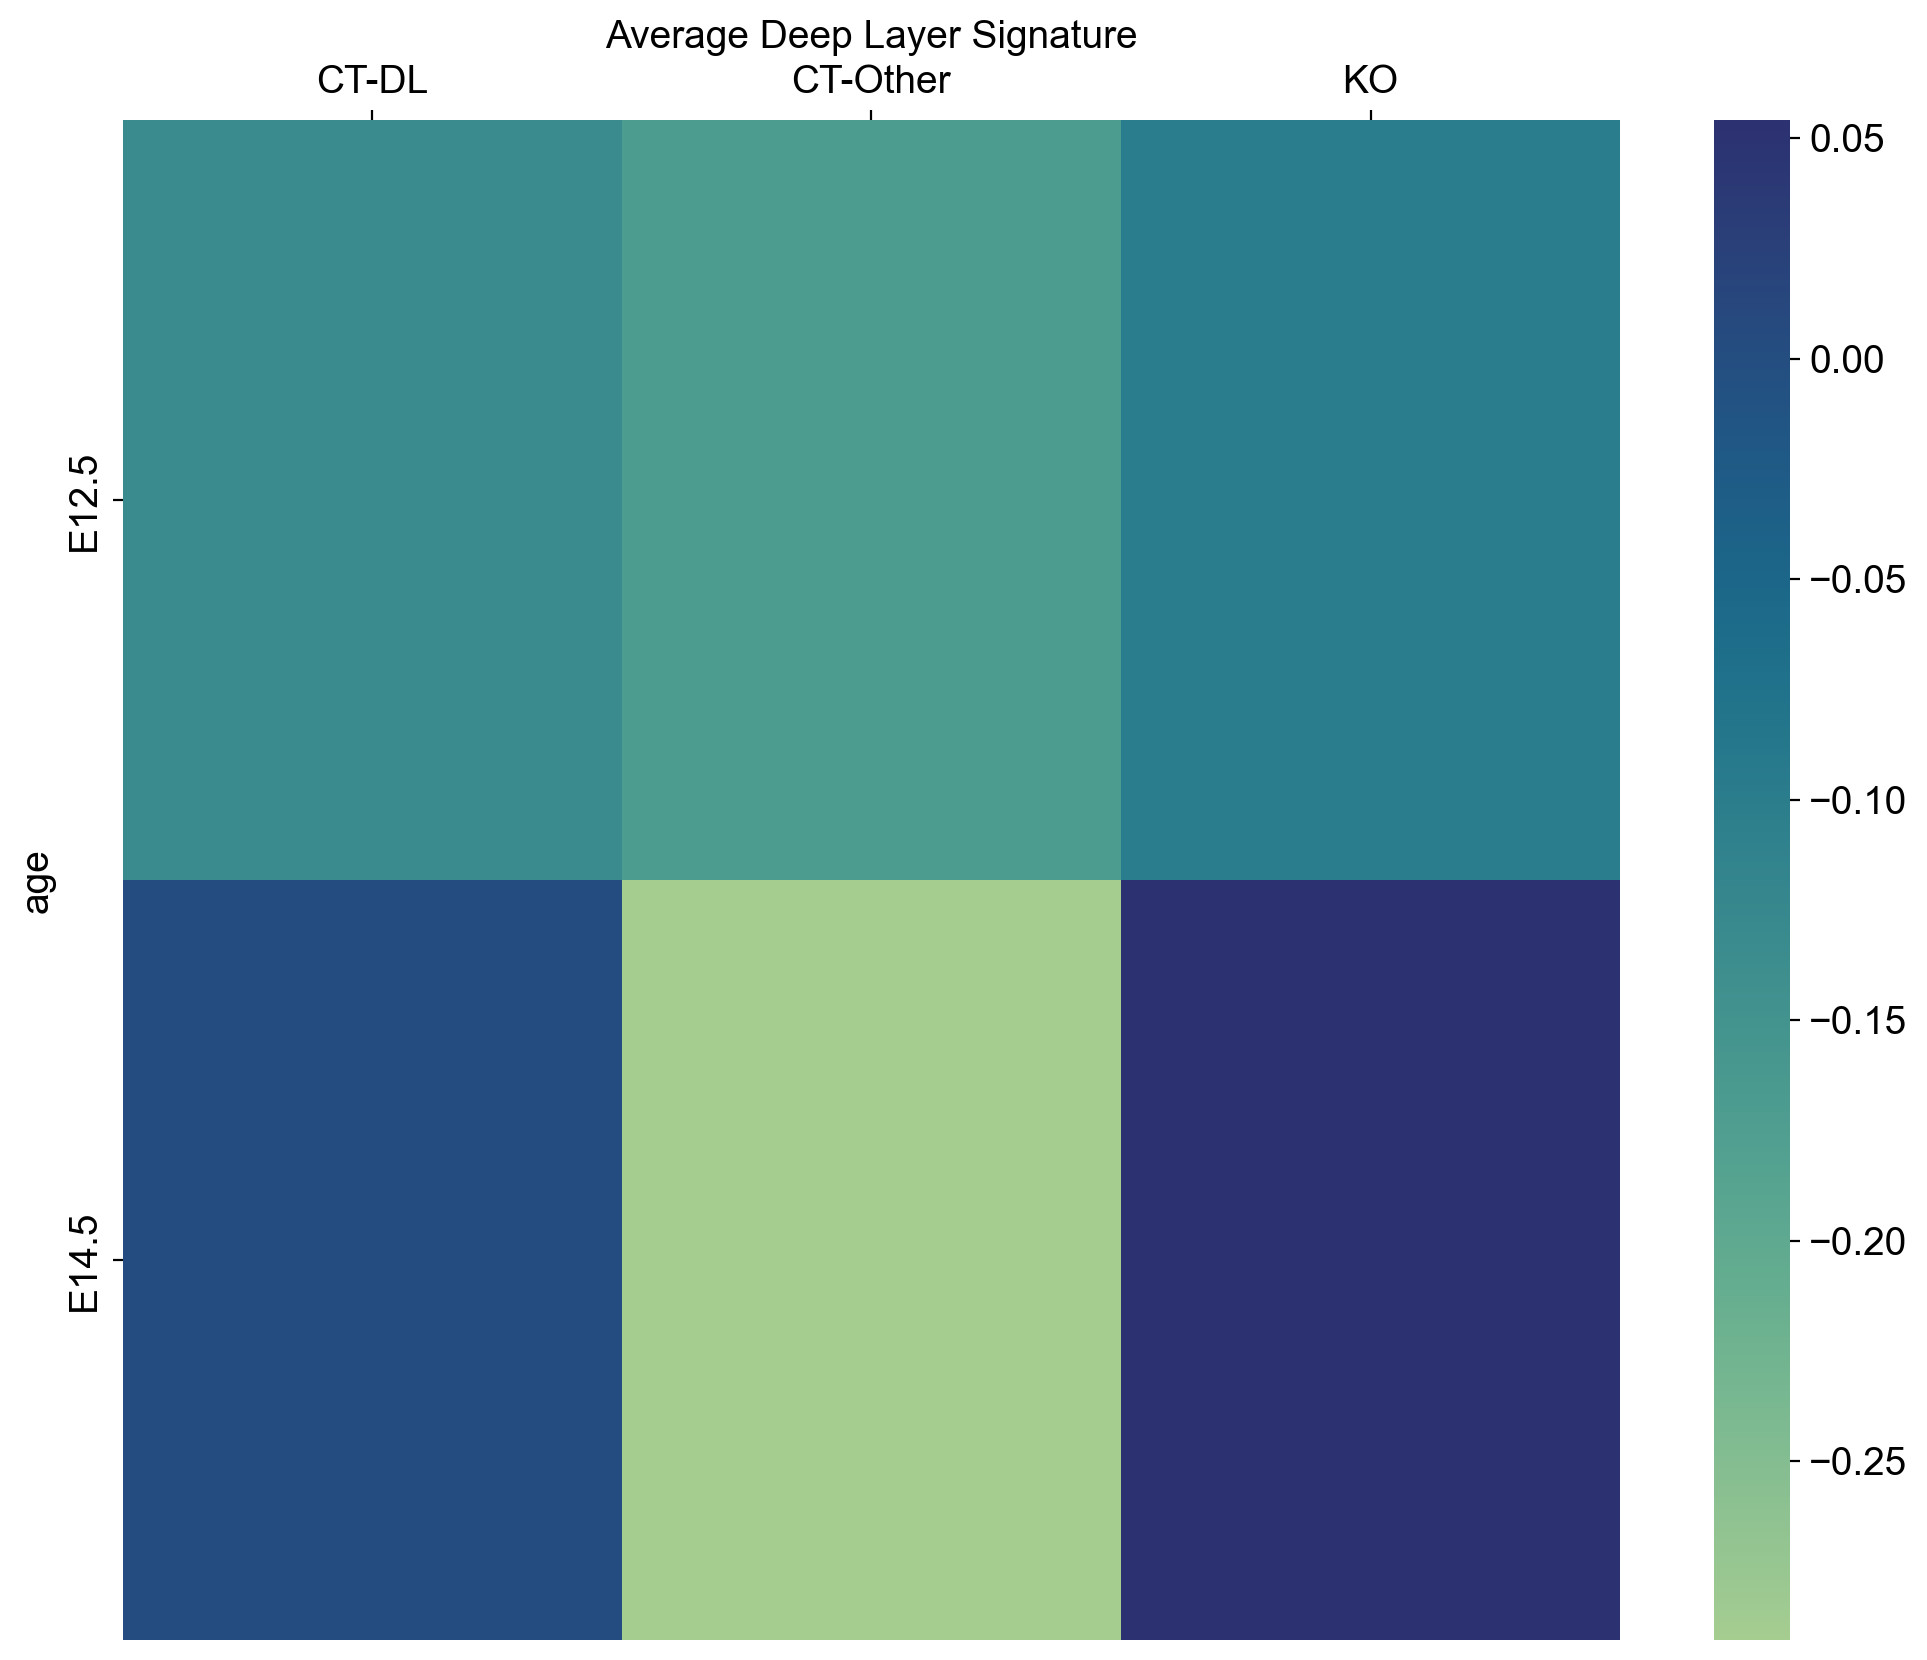

In [8]:
ax = sns.heatmap(df_pivot[['DL_signature']],xticklabels = ['CT-DL','CT-Other','KO'],cmap = 'crest')
ax.grid(False)
ax.set(xlabel="")
ax.xaxis.tick_top()
ax.set_title('Average Deep Layer Signature')
#ax.figure.savefig('average_DL_signature.pdf')

Text(0.5, 1.0, 'Average Upper Layer Signature')

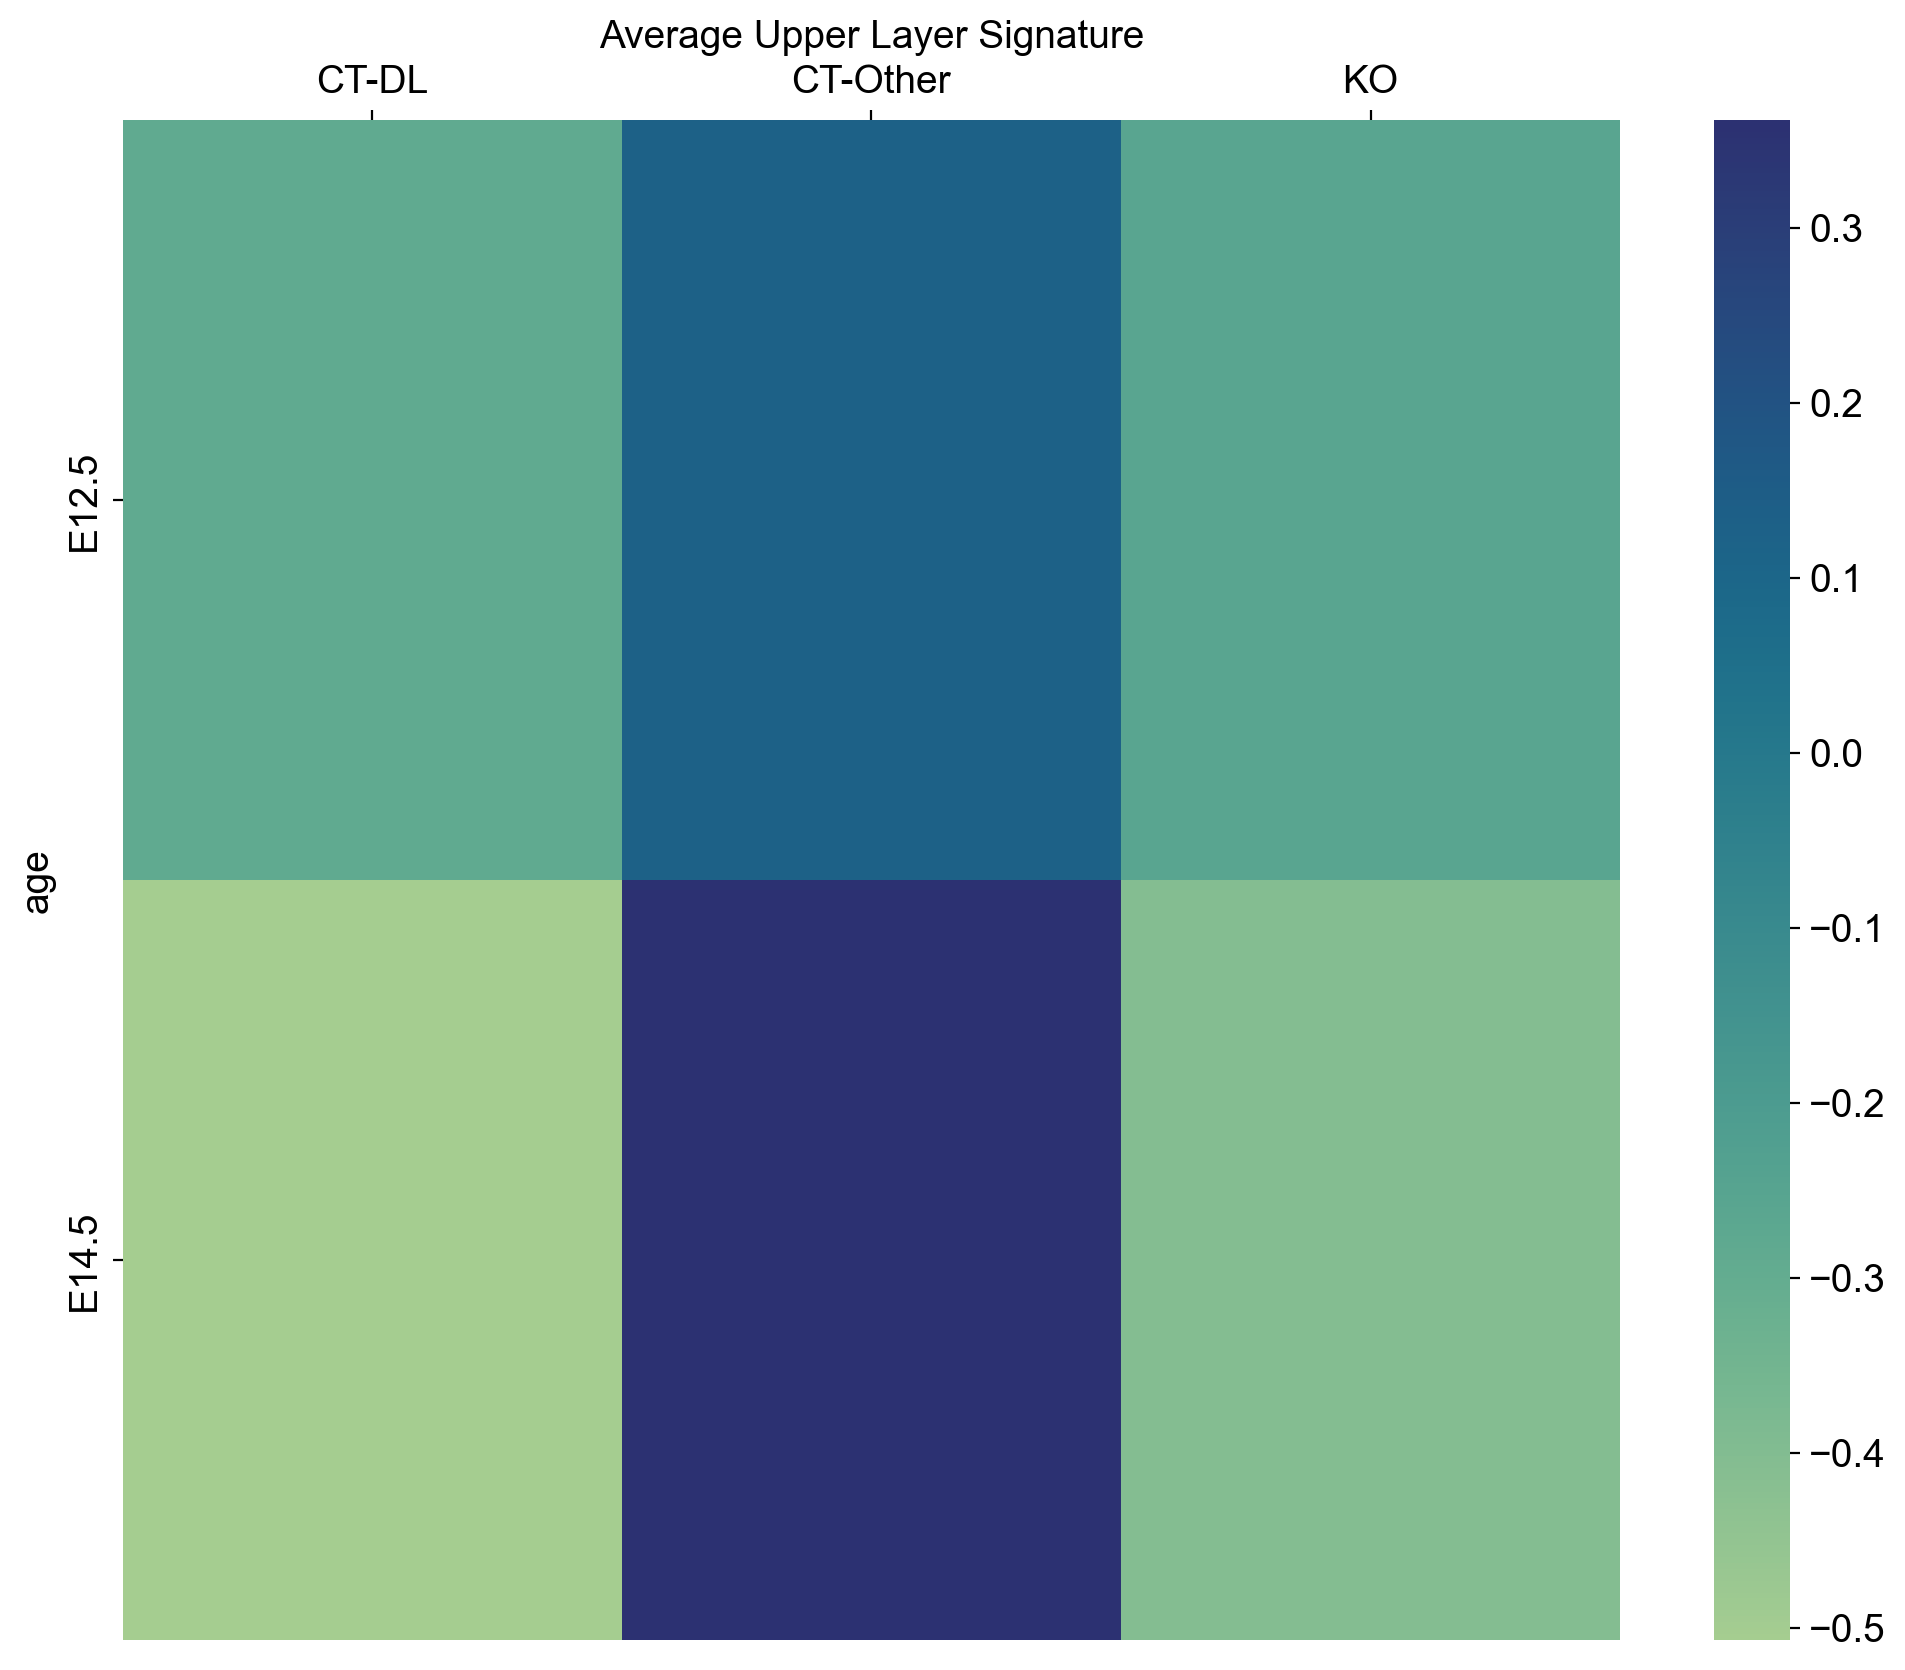

In [9]:
ax = sns.heatmap(df_pivot[['UL_signature']],xticklabels = ['CT-DL','CT-Other','KO'],cmap = 'crest')
ax.grid(False)
ax.set(xlabel="")
ax.xaxis.tick_top()
ax.set_title('Average Upper Layer Signature')
#ax.figure.savefig('average_UL_signature.pdf')

In [10]:
adata.layers['count'] = adata.X.copy()

sc.pp.normalize_total(adata)
sc.pp.log1p(adata)

In [11]:
genes = ['Sez6','Wnt7b','Chl1','Xpr1','Sox5','Rgs16','Cblb','Zfpm2','Dpysl4','Apcdd1','Socs2','Zfp703','Dpy19l3','Foxp2',
            'Nab1','Necab3','Adamts20','Tbr1','Vcan',
'Celf4','Rasl11b','Csrnp3','Inhba', 'Nxph1','Mn1','Dok5','Frmd4a','Dact1', 
            'Epha3', 'Gabra2','Palmd', 'Neurod1','Sema3a','Pdgfa', 'Tmem158']

In [12]:
df = pd.DataFrame(adata[:,adata.var['gene_short_name'].isin(genes)].X.todense())
df.columns = adata.var[adata.var['gene_short_name'].isin(genes)]['gene_short_name'].to_list()

df = df.loc[:,~(df==0).all(axis = 0)]
df[['age.x','condition.x','DL']] = adata.obs[['age.x','condition.x','DL']].values
df['DL'][df['condition.x'] == 'ko'] = 'ko'

In [14]:
df_pivot = pd.pivot_table(df,values = genes,index = ['age.x'],columns = ['DL'],aggfunc = 'mean').T.unstack()

In [15]:
mask = np.triu(np.ones_like(df_pivot[12.5].corr(),dtype=bool))
np.fill_diagonal(mask,False)

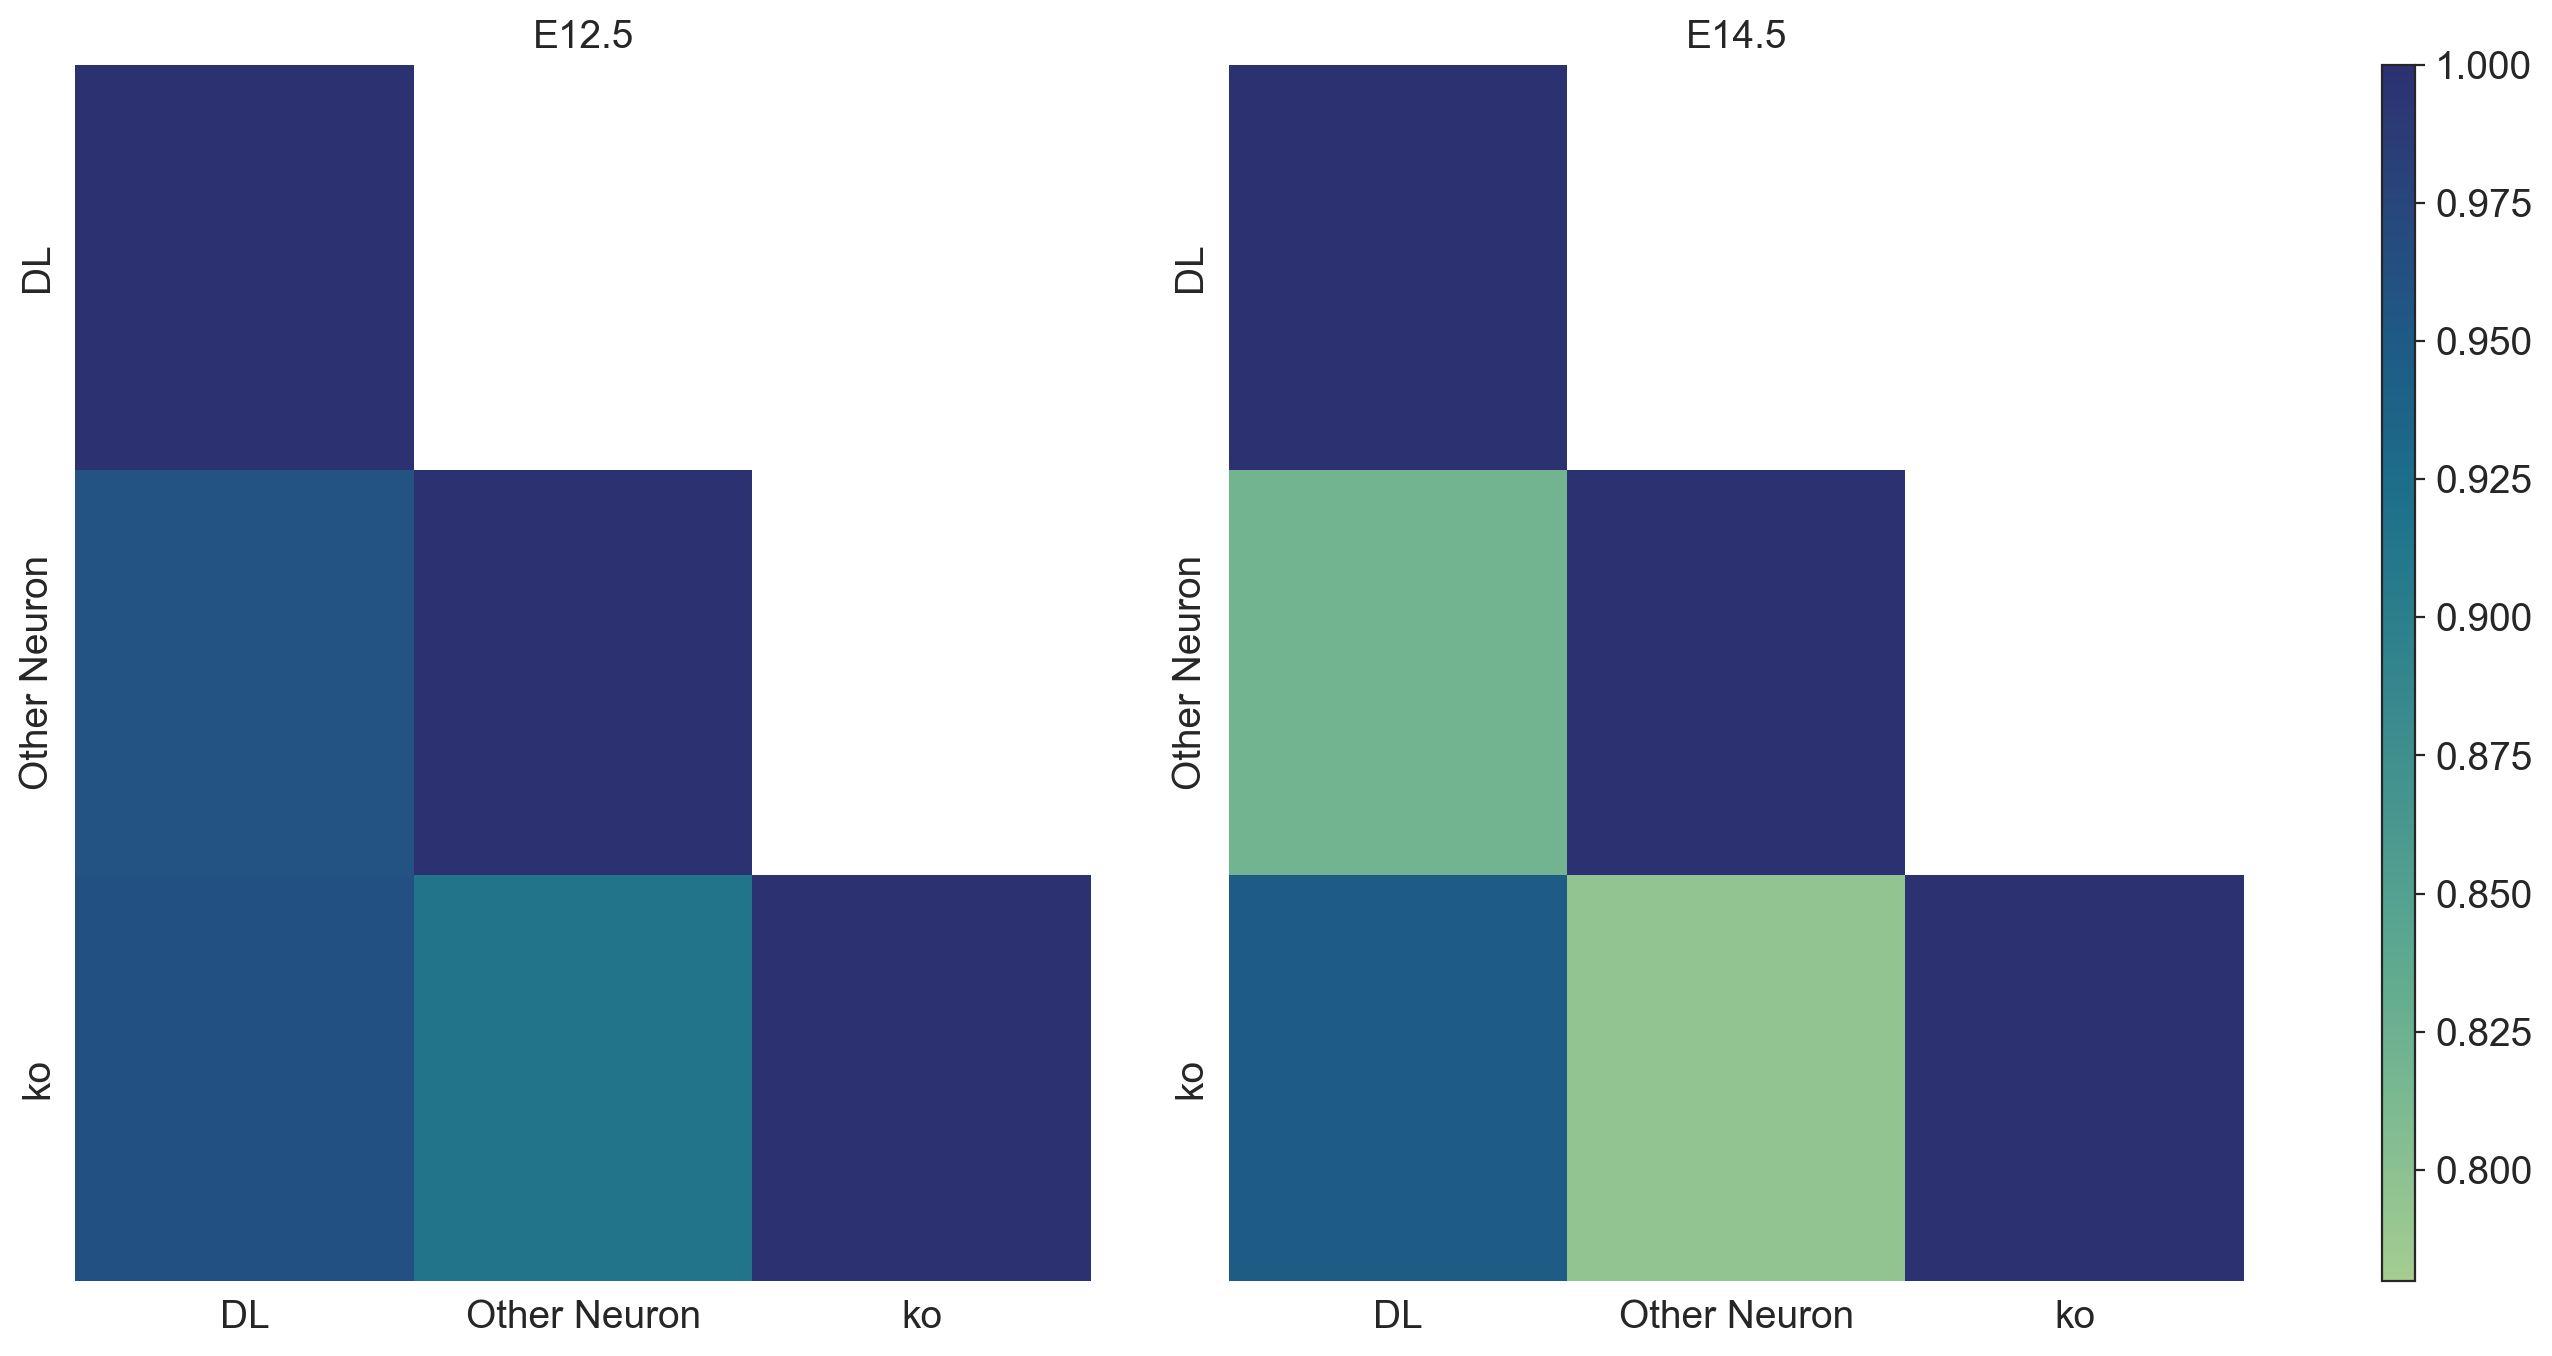

In [18]:
fig,ax = plt.subplots(ncols = 3,gridspec_kw = dict(width_ratios = [3,3,0.1]),figsize = (15,8))
sns.set_style('white')
sns.heatmap(df_pivot[12.5].corr(),cmap = 'crest',ax = ax[0],vmin = 0.78,cbar = False,mask = mask)
sns.heatmap(df_pivot[14.5].corr(),cmap = 'crest',ax = ax[1],vmin = 0.78,cbar = False,mask = mask)
ax[0].set(xlabel = '',ylabel = '')
ax[0].set_title('E12.5')
ax[1].set(xlabel = '',ylabel = '')
ax[1].set_title('E14.5')
ax[0].grid(False)
fig.colorbar(ax[0].collections[0],cax = ax[2])
plt.show()
#fig.savefig('DL_and_UL_signature_genes_correlation_v2.pdf')